In [1]:
import os
import sys
from datetime import datetime

In [2]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
BASE_DIR = os.path.abspath("../")
sys.path.append(BASE_DIR)

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------
from src.utils.config import load_config
config = load_config(base_dir=BASE_DIR)

In [19]:
import time
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import TruncatedSVD
from dask_ml.decomposition import IncrementalPCA
from dask_ml.decomposition import PCA as DaskPCA
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import numpy as np


In [4]:
config["paths"]["tensors_pca"]

'/Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/data/processed/visa_trx/tensors_pca'

# Mathematical embedding - PCA

In [20]:
start_time = time.time()

# Leer CSV
individual_tensors = config["paths"]["tensors_convolution"]
data = dd.read_csv(individual_tensors)

# Separar ID y datos numéricos
id_col_name = data.columns[0]
df_num = data.iloc[:, 1:].astype(float)

print("to_dask_array ")
X = df_num.to_dask_array(lengths=True)

# Escalado (Dask-ML)
print("Escalado (Dask-ML) ")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Limpiar columnas problemáticas
print("Limpiando NaNs/Infs y columnas constantes")
X_scaled = da.where(da.isnan(X_scaled), 0, X_scaled)
X_scaled = da.where(da.isposinf(X_scaled), 0, X_scaled)
X_scaled = da.where(da.isneginf(X_scaled), 0, X_scaled)

col_std = X_scaled.std(axis=0).compute()
non_constant_cols = (col_std != 0)
X_scaled = X_scaled[:, non_constant_cols]

# IncrementalPCA sin cargar en memoria
# print("IncrementalPCA ")
# n_components = 30
# pca = IncrementalPCA(n_components=n_components)
# X_reduced = pca.fit_transform(X_scaled)

print("Dask PCA")
n_components = 30
pca = DaskPCA(n_components=n_components, svd_solver="randomized")
X_reduced = pca.fit_transform(X_scaled)

# Convertir resultado a Dask-DF
print("to dask ")
pca_cols = [f"pca_{i}"for i in range(n_components)]
df_pca = dd.from_dask_array(X_reduced, columns=pca_cols)

# Reemplazar las columnas numéricas por las componentes PCA
print("Reemplazando columnas con PCA")
result = data[[id_col_name]]  # Solo la columna ID
result = result.repartition(npartitions=df_pca.npartitions)

# Concatenar usando map_partitions
def concat_partitions(id_part, pca_part):
    return pd.concat([id_part.reset_index(drop=True), 
                      pca_part.reset_index(drop=True)], axis=1)

result = dd.map_partitions(
    concat_partitions,
    result,
    df_pca,
    meta={id_col_name: data[id_col_name].dtype, **{col: 'float64' for col in pca_cols}}
)

# Guardar sin computar en RAM
print("Write ")
tensors_pca = config["paths"]["tensors_pca"]
os.makedirs(os.path.dirname(tensors_pca), exist_ok=True)
with ProgressBar():
    result.to_parquet(tensors_pca, write_index=False)


end_time = time.time()
print(f"\n⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

to_dask_array 
Escalado (Dask-ML) 
Limpiando NaNs/Infs y columnas constantes
Dask PCA
to dask 
Reemplazando columnas con PCA
Write 
[########################################] | 100% Completed | 123.09 s

⏰ Start: Thu Nov 27 20:46:58 2025
🏁 End:   Thu Nov 27 20:57:00 2025
⏱️ Total: 602.47 sec (10.04 min)


In [21]:
result.head(2)

,row_id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29
0,+++AhJk2QJM=_0,1.919663,4.697275,1.116261,-4.769926,7.889935,2.320686,-1.293927,0.996005,0.432205,...,0.880392,0.058230,0.577950,2.424353,-0.275948,-0.255943,0.408298,-0.476823,-0.454765,0.445993
1,+++AhJk2QJM=_1,-2.513715,-1.814875,3.243758,-0.876881,0.393479,-0.900246,1.228662,1.062382,1.216977,...,-0.115098,0.648283,0.953769,0.430935,0.138819,-0.150272,0.409697,0.132581,-0.482442,0.370543


In [22]:
# Mostrar varianza explicada
print(f"\n📊 Varianza explicada por componente:")
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Total acumulada: {explained_variance.sum()*100:.2f}%")


📊 Varianza explicada por componente:
PC0: 21.54%
PC1: 8.73%
PC2: 7.74%
PC3: 6.80%
PC4: 6.19%
PC5: 3.77%
PC6: 3.61%
PC7: 3.29%
PC8: 2.83%
PC9: 2.52%
PC10: 2.31%
PC11: 2.09%
PC12: 1.90%
PC13: 1.65%
PC14: 1.44%
PC15: 1.34%
PC16: 1.17%
PC17: 1.00%
PC18: 0.93%
PC19: 0.81%
PC20: 0.79%
PC21: 0.66%
PC22: 0.61%
PC23: 0.58%
PC24: 0.53%
PC25: 0.44%
PC26: 0.43%
PC27: 0.38%
PC28: 0.35%
PC29: 0.30%
Total acumulada: 86.72%


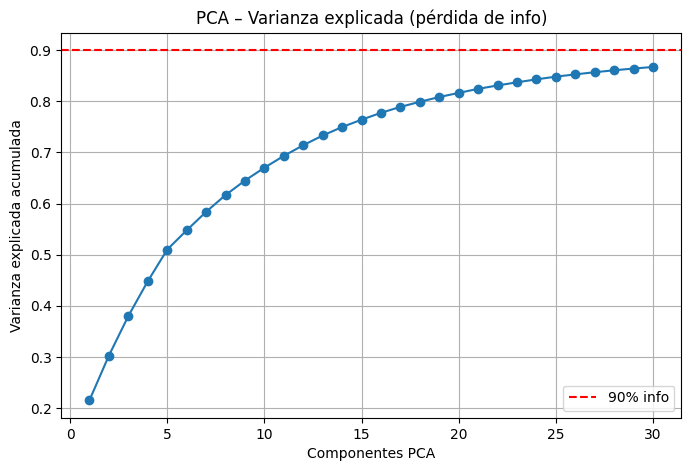

In [23]:

# Varianza explicada por cada componente
var_exp = pca.explained_variance_ratio_
cum_var = np.cumsum(var_exp)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% info')
plt.xlabel("Componentes PCA")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA – Varianza explicada (pérdida de info)")
plt.grid(True)
plt.legend()
plt.show()

# Mathematical embedding - truncateSVD

In [ ]:
start_time = time.time()

# Leer CSV
individual_tensors = config["paths"]["tensors_convolution"]
data = dd.read_csv(individual_tensors)

# Separar ID y datos numéricos
id_col_name = data.columns[0]
df_num = data.iloc[:, 1:].astype(float)

print("to_dask_array ")
X = df_num.to_dask_array(lengths=True)

# Escalado (Dask-ML)
print("Escalado (Dask-ML) ")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Limpiar columnas problemáticas
print("Limpiando NaNs/Infs y columnas constantes")
X_scaled = da.where(da.isnan(X_scaled), 0, X_scaled)
X_scaled = da.where(da.isposinf(X_scaled), 0, X_scaled)
X_scaled = da.where(da.isneginf(X_scaled), 0, X_scaled)

col_std = X_scaled.std(axis=0).compute()
non_constant_cols = (col_std != 0)
X_scaled = X_scaled[:, non_constant_cols]

# SVD sin cargar en memoria
print("SVD ")
n_components = 30
tsvd = TruncatedSVD(n_components=n_components)
X_reduced = tsvd.fit_transform(X_scaled)

# Convertir resultado a Dask-DF
print("to dask ")
svd_cols = [f"svd_{i}"for i in range(n_components)]
df_svd = dd.from_dask_array(X_reduced, columns=svd_cols)

# **SOLUCIÓN SIMPLE**: Reemplazar las columnas numéricas por las componentes SVD
print("Reemplazando columnas con SVD")
# Mantener solo la columna ID del DataFrame original y agregar las componentes SVD
result = data[[id_col_name]]  # Solo la columna ID
result = result.repartition(npartitions=df_svd.npartitions)

# Concatenar usando map_partitions
def concat_partitions(id_part, svd_part):
    return pd.concat([id_part.reset_index(drop=True), 
                      svd_part.reset_index(drop=True)], axis=1)

result = dd.map_partitions(
    concat_partitions,
    result,
    df_svd,
    meta={id_col_name: data[id_col_name].dtype, **{col: 'float64' for col in svd_cols}}
)

# Guardar sin computar en RAM
print("Write ")
tensors_svd = config["paths"]["tensors_svd"]
os.makedirs(os.path.dirname(tensors_svd), exist_ok=True)
with ProgressBar():
    result.to_parquet(tensors_svd, write_index=False)

end_time = time.time()
print(f"⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

to_dask_array 
Escalado (Dask-ML) 
Limpiando NaNs/Infs y columnas constantes
SVD 
to dask 
Reemplazando columnas con SVD
Write 
[########################################] | 100% Completed | 192.91 s
⏰ Start: Thu Nov 27 16:33:48 2025
🏁 End:   Thu Nov 27 16:40:32 2025
⏱️ Total: 404.19 sec (6.74 min)


In [13]:
result.head(2)

,row_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29
0,+++AhJk2QJM=_0,2.321137,5.796435,0.322699,-4.752074,7.721672,1.344247,-1.893400,1.359591,0.227430,...,0.652658,0.270227,-1.029595,2.147013,2.037184,-0.640797,-0.863447,0.187607,-0.830994,-0.646260
1,+++AhJk2QJM=_1,-2.189485,-1.675791,3.044567,-0.866251,0.999664,0.226042,2.207145,0.854363,0.442009,...,0.267057,-0.263182,0.525758,0.534575,0.520738,-0.026368,-1.143669,0.200304,-0.483873,-0.058096


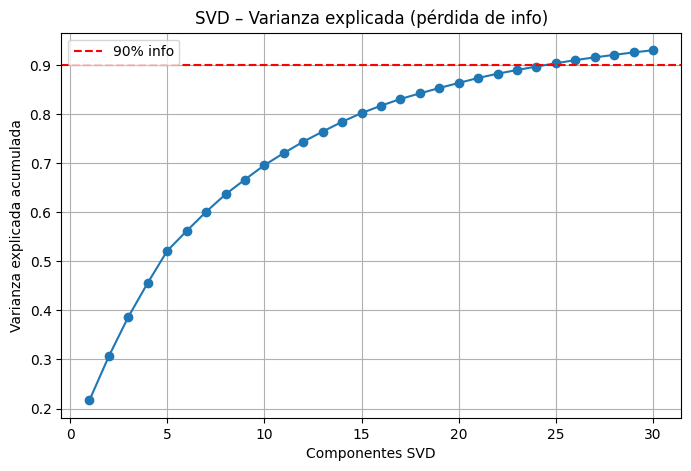

In [14]:
import matplotlib.pyplot as plt
import numpy as np

var_exp = tsvd.explained_variance_ratio_
cum_var = np.cumsum(var_exp)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% info')
plt.xlabel("Componentes SVD")
plt.ylabel("Varianza explicada acumulada")
plt.title("SVD – Varianza explicada (pérdida de info)")
plt.grid(True)
plt.legend()
plt.show()


# end

| Método de escalado      | Qué hace                                 | Preserva dirección | Ideal para Cosine | Ideal para Euclidean | Ideal para Manhattan (L1) | Ideal para Minkowski | Adecuado para K-Means | Comentarios clave |
|--------------------------|-------------------------------------------|---------------------|--------------------|------------------------|---------------------------|------------------------|------------------------|--------------------|
| **L2 Normalization**     | Normaliza cada vector a norma 1 (‖x‖₂=1) | ✔ Sí               | ⭐ **Sí** (equivalencia exacta) | ✔ Sí (si magnitud no importa) | ❌ No (distorsiona L1) | ❌ No | ⭐ **Sí (cuando quieres imitar Cosine-KMeans)** | Convierte Euclidean en Cosine; ideal para embeddings y perfiles. |
| **StandardScaler**       | Centra y escala cada feature (z-score)   | ❌ No              | ❌ **No** | ⭐ **Sí** (distancia euclidiana clásica) | ⭐ **Sí** | ⭐ **Sí** | ⭐ **Sí** | Mantiene variancia comparable entre features; estándar para ML tradicional. |
| **MinMaxScaler**         | Escala cada feature a [0,1]              | ❌ No              | ❌ No | ⭐ Sí (cuando las escalas importan) | ⭐ Sí | ⭐ Sí | ⭐ Sí | Preserva relaciones relativas; útil en clustering basado en distancias mixtas. |
| **RobustScaler**         | Escala usando medianas y IQR             | ❌ No              | ❌ No | ⭐ Sí (robusto a outliers) | ⭐ Sí | ⭐ Sí | ⭐ Sí | Excelente cuando hay outliers fuertes; no apto para coseno. |
| **None (sin escala)**    | Deja los datos crudos                    | A veces            | ❌ No | ❌ No (si las escalas varían entre features) | ❌ No | ❌ No | ❌ No | Solo útil si todas las features ya están en la misma escala y sin outliers. |


In [15]:
import time
import dask.dataframe as dd
import dask.array as da

### Normalization 01

In [ ]:
start_time = time.time()

# Leer datos
tensors_svd = config["paths"]["tensors_svd"]
input_path = tensors_svd
data = dd.read_parquet(input_path)

id_col = "row_id"
value_cols = [c for c in data.columns if c != id_col]

# Convertir a Dask array
X = data[value_cols].astype(float).to_dask_array(lengths=True)
row_ids = data[id_col].to_dask_array(lengths=True).reshape(-1, 1)

# Normalización Min-Max (0-1)
print("Calculando min y max por fila...")
X_min = da.min(X, axis=1, keepdims=True)
X_max = da.max(X, axis=1, keepdims=True)

# Evitar división por cero (cuando min == max)
X_range = X_max - X_min
X_range = da.where(X_range == 0, 1, X_range)

# Normalizar: (X - min) / (max - min)
X_norm_01 = (X - X_min) / X_range

# Combinar con IDs
full_array = da.hstack([row_ids, X_norm_01])
df_norm_01 = dd.from_dask_array(full_array, columns=[id_col] + value_cols)

# Guardar
output_path_01 = config["paths"]["tensors_normalized_01"]
os.makedirs(os.path.dirname(output_path_01), exist_ok=True)
print("Guardando normalización 0-1...")
df_norm_01.to_parquet(output_path_01, write_index=False)

end_time = time.time()
print(f"⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

### Normalization L1

In [16]:
start_time = time.time()

# individual_tensors = config["paths"]["tensors_convolution"]
tensors_svd = config["paths"]["tensors_svd"]
inpust_path = tensors_svd
data = dd.read_parquet(inpust_path)
data = data.repartition(npartitions=data.npartitions)

id_col = "row_id"
value_cols = [c for c in data.columns if c != id_col]

X = data[value_cols].astype(float).to_dask_array(lengths=True)
row_ids = data[id_col].to_dask_array(lengths=True).reshape(-1, 1)

L1_norms = da.sum(da.abs(X), axis=1, keepdims=True)
L1_norms = da.where(L1_norms == 0, 1, L1_norms)
X_norm_L1 = X / L1_norms

full_array = da.hstack([row_ids, X_norm_L1])
df_norm_L1 = dd.from_dask_array(full_array, columns=[id_col] + value_cols)

output_path_L1 = config["paths"]["tensors_normalized_L1"]
os.makedirs(os.path.dirname(tensors_svd), exist_ok=True)
df_norm_L1.to_parquet(output_path_L1, write_index=False)

end_time = time.time()
print(f"⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

/Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/.venv/lib/python3.13/site-packages/dask/dataframe/dask_expr/_collection.py:1435: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


⏰ Start: Thu Nov 27 16:43:33 2025
🏁 End:   Thu Nov 27 16:47:59 2025
⏱️ Total: 266.55 sec (4.44 min)


### Normalization L2

In [17]:
start_time = time.time()

# individual_tensors = config["paths"]["tensors_convolution"]
tensors_svd = config["paths"]["tensors_svd"]
inpust_path = tensors_svd
data = dd.read_parquet(inpust_path)
data = data.repartition(npartitions=data.npartitions)

id_col = "row_id"
value_cols = [c for c in data.columns if c != id_col]

X = data[value_cols].astype(float).to_dask_array(lengths=True)
row_ids = data[id_col].to_dask_array(lengths=True).reshape(-1, 1)

L2_norms = da.linalg.norm(X, axis=1, keepdims=True)
L2_norms = da.where(L2_norms == 0, 1, L2_norms)
X_norm_L2 = X / L2_norms

full_array = da.hstack([row_ids, X_norm_L2])
df_norm_L2 = dd.from_dask_array(full_array, columns=[id_col] + value_cols)

output_path_L2 = config["paths"]["tensors_normalized_L2"]
os.makedirs(os.path.dirname(tensors_svd), exist_ok=True)
df_norm_L2.to_parquet(output_path_L2, write_index=False)

end_time = time.time()
print(f"⏰ Start: {time.ctime(start_time)}")
print(f"🏁 End:   {time.ctime(end_time)}")
print(f"⏱️ Total: {end_time - start_time:.2f} sec ({(end_time - start_time)/60:.2f} min)")

/Users/jkn/Documents/Projects/university/tensor_behavioral_pattern_mining/.venv/lib/python3.13/site-packages/dask/dataframe/dask_expr/_collection.py:1435: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


⏰ Start: Thu Nov 27 16:47:59 2025
🏁 End:   Thu Nov 27 16:52:24 2025
⏱️ Total: 264.44 sec (4.41 min)
